In [1]:
#Import Packages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
from sklearn import tree
import numpy as np
import json

In [2]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('/home/borna/ProcessMining/Assignments/Process_Mining/conformance_checking/data/df_for_decision_tree.csv')

# Display the first few rows of the dataframe
df.head()


,trace_number,start_log_moves,start_model_moves,A-Create-Application_log_moves,A-Create-Application_model_moves,A-Submitted_log_moves,A-Submitted_model_moves,W-Handle-leads-schedule_log_moves,W-Handle-leads-schedule_model_moves,W-Handle-leads-withdraw_log_moves,...,W-Handle-leads-ate-abort_model_moves,W-Shortened-completion-schedule_log_moves,W-Shortened-completion-schedule_model_moves,W-Shortened-completion-start_log_moves,W-Shortened-completion-start_model_moves,W-Shortened-completion-suspend_log_moves,W-Shortened-completion-suspend_model_moves,W-Call-after-offers-withdraw_log_moves,W-Call-after-offers-withdraw_model_moves,case:throughput_time
0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13 days 15:06:16.631000
1,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30 days 04:47:52.288000
2,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 days 02:13:02.807000
3,3,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21 days 20:18:42.905000
4,4,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20 days 02:25:54.292000


In [3]:
class DecisionTreeModel:
    """
    A class used to represent a Decision Tree Model for predicting case throughput time.

    Attributes
    ----------
    json_file_path : str
        The path to the JSON file containing the parameter grid for GridSearchCV.
    random_state : int
        The seed used by the random number generator.
    test_size : float
        The proportion of the dataset to include in the test split.
    grid_search : GridSearchCV, optional
        The GridSearchCV object after fitting the model.

    Methods
    -------
    load_param_grid():
        Loads the parameter grid from a JSON file.
    
    preprocess_data(df):
        Preprocesses the input DataFrame by filling missing values, excluding certain columns, and converting the target variable to hours.
    
    train_model(df):
        Trains the Decision Tree model using GridSearchCV to find the best parameters.
    
    Returns
    -------
    dict
        The parameter grid dictionary.
    """
    def __init__(self, json_file_path='param_grid.json', random_state=42, test_size=0.2):
        self.json_file_path = json_file_path
        self.random_state = random_state
        self.test_size = test_size
        self.grid_search = None

    def load_param_grid(self):
        with open(self.json_file_path, 'r') as file:
            param_grid = json.load(file)
        return param_grid

    def preprocess_data(self, df):
        df_filled = df.fillna(-1)
        columns_to_exclude = ["trace_number", "None_log_moves", "None_model_moves"]
        X = df_filled.drop(columns=columns_to_exclude + ["case:throughput_time"])
        y = df_filled["case:throughput_time"]
        y_timedelta = pd.to_timedelta(y)
        y_hours = y_timedelta.apply(lambda x: x.total_seconds() / 3600)
        return X, y_hours

    def train_model(self, df):
        X, y_hours = self.preprocess_data(df)
        # Identify columns with -1 and transform
        columns_with_negative = (X == -1).any(axis=0)
        if columns_with_negative.any():
            for col in X.columns[columns_with_negative]:
                # Replace -1 with a custom flag or leave as is if logical
                X[col] = X[col].apply(lambda x: 0 if x == -1 else x)  # Custom replacement logic
        X_train, X_test, y_train, y_test = train_test_split(X, y_hours, test_size=self.test_size, random_state=self.random_state)
        param_grid = self.load_param_grid()
        tree_regressor = DecisionTreeRegressor(random_state=self.random_state)
        self.grid_search = GridSearchCV(
            estimator=tree_regressor,
            param_grid=param_grid,
            cv=5,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=2
        )
        self.grid_search.fit(X_train, y_train)
        print("Best Parameters found in Grid Search:", self.grid_search.best_params_)

# Usage
model = DecisionTreeModel(json_file_path='param_grid.json', random_state=42, test_size=0.2)
model.train_model(df)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END max_depth=3, max_features=5, min_samples_leaf=40, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=40, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=40, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=50, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=50, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=50, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=50, min_samples_split=60; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=40, min_samples_split=80; total time=   0.0s
[CV] END max_depth=3, max_features=5, min_samples_leaf=50, min_samples_split=80; total time=   0.0s
[CV] END max_depth=3, max_features=5, 

Model Performance:
Best Parameters: {'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 50, 'min_samples_split': 60}
Mean Absolute Error (MAE): 171.89 hours
Root Mean Squared Error (RMSE): 243.41 hours
R-squared (R2): 0.10
  Actual Throughput Time (Hours) Predicted Throughput Time (Hours)
0        20 days 00:56:41.258000        16 days 20:30:22.433741460
1     41 days 08:53:06.929999998        21 days 20:01:54.943349649
2      8 days 11:57:34.908999998        10 days 08:29:26.384975088
3     21 days 18:28:18.203999998        18 days 11:25:24.199008927
4      0 days 00:57:59.281999999        13 days 08:53:32.135194806
Decision tree figure saved as decision_tree.png


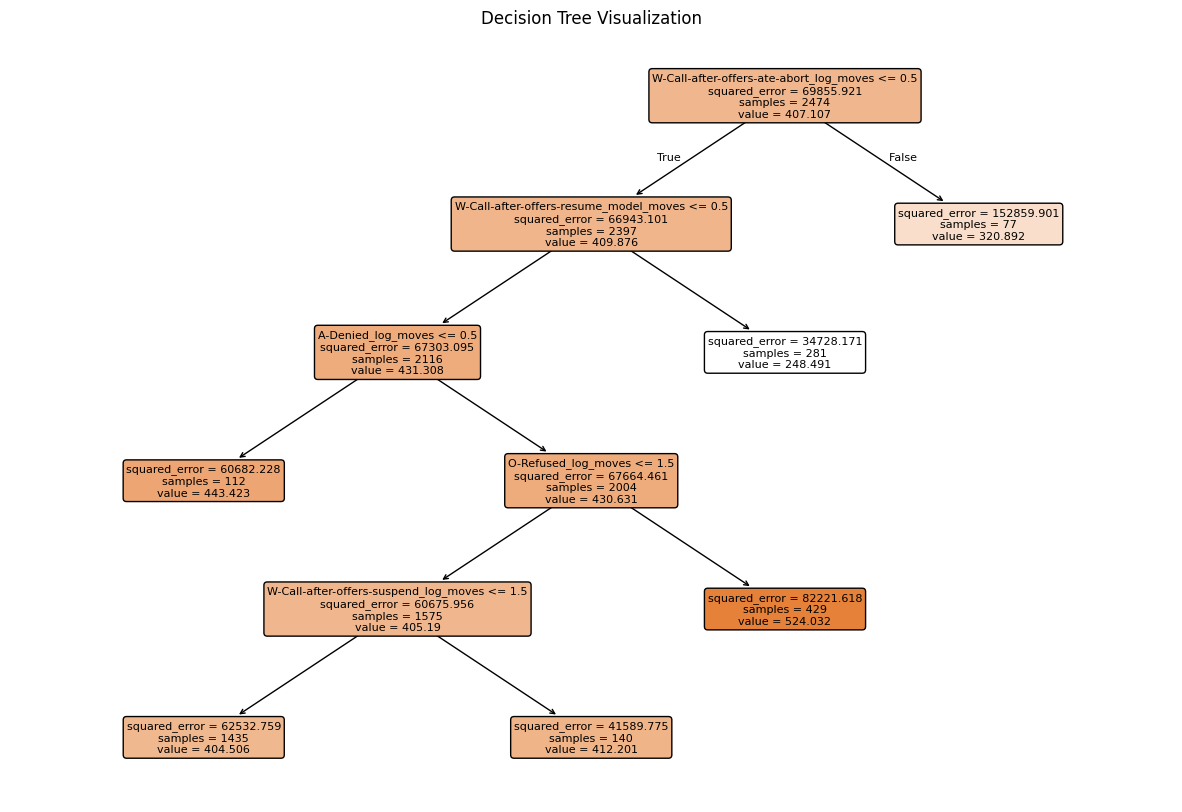

In [4]:
class DecisionTreeEvaluator:
    """
    A class used to evaluate a trained Decision Tree model for predicting case throughput time.

    Methods
    -------
    evaluate_model(grid_search, X_test, y_test, save_fig=False, fig_path='decision_tree.png'):
        Evaluates the best model from the grid search on the test set and calculates evaluation metrics.
    """

    @staticmethod
    def evaluate_model(grid_search, X_test, y_test, save_fig=False, fig_path='decision_tree.png'):
        """
        Evaluates the best model from the grid search on the test set and calculates evaluation metrics.

        Parameters
        ----------
        grid_search : GridSearchCV
            The GridSearchCV object after fitting the model.
        X_test : DataFrame
            The test set features.
        y_test : Series
            The actual throughput time in hours for the test set.
        save_fig : bool, optional
            Whether to save the decision tree figure as a PNG file (default is False).
        fig_path : str, optional
            The path to save the decision tree figure if save_fig is True (default is 'decision_tree.png').

        Returns
        -------
        dict
            A dictionary containing the evaluation metrics and the first few results for interpretation.
        """
        # Extract the best model from the grid search
        best_tree_model = grid_search.best_estimator_

        # Evaluate the best model on the test set
        y_pred_hours = best_tree_model.predict(X_test)

        # Convert predictions back to timedelta format for interpretation
        y_pred_timedelta = pd.Series(y_pred_hours).apply(lambda hours: pd.to_timedelta(hours, unit='h'))
        y_test_timedelta = pd.Series(y_test).apply(lambda hours: pd.to_timedelta(hours, unit='h'))

        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred_hours)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_hours))
        r2 = r2_score(y_test, y_pred_hours)

        print("Model Performance:")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Mean Absolute Error (MAE): {mae:.2f} hours")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f} hours")
        print(f"R-squared (R2): {r2:.2f}")

        # Display first few results for interpretation
        results_df = pd.DataFrame({
            'Actual Throughput Time (Hours)': y_test_timedelta.reset_index(drop=True),
            'Predicted Throughput Time (Hours)': y_pred_timedelta
        })
        print(results_df.head())

        # Visualize the decision tree to understand decision rules
        plt.figure(figsize=(15, 10))
        tree.plot_tree(best_tree_model, feature_names=X_test.columns, filled=True, rounded=True, fontsize=8)
        plt.title("Decision Tree Visualization")

        if save_fig:
            plt.savefig(fig_path)
            print(f"Decision tree figure saved as {fig_path}")

        plt.show()

        return {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'results_df': results_df
        }

# Usage
X, y_hours = model.preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y_hours, test_size=model.test_size, random_state=model.random_state)
evaluator = DecisionTreeEvaluator()
evaluation_results = evaluator.evaluate_model(model.grid_search, X_test, y_test, save_fig=True, fig_path='decision_tree.png')

In [39]:
from typing import List, Dict, Tuple
import pandas as pd
from sklearn.tree import _tree

def extract_rules_from_tree(decision_tree_model, feature_names: List[str], target_name: str) -> List[Dict[str, any]]:
    """
    Extract rules by traversing from the root to each leaf in the trained decision tree model.
    
    Parameters
    ----------
    decision_tree_model : sklearn.tree.DecisionTreeRegressor
        The trained decision tree model from which to extract path-based rules.
    feature_names : List[str]
        List of feature names to interpret tree splits.
    target_name : str
        The name of the target variable, for leaf-level output interpretation.
        
    Returns
    -------
    List[Dict[str, any]]
        A list of dictionaries, each representing a rule with:
            - 'conditions': List of conditions (feature, operator, threshold) for the path.
            - 'average_gini': Average Gini impurity encountered along the path.
            - 'final_gini': Gini impurity at the leaf node.
            - 'average_throughput_time': Average value of target (throughput time) at the leaf node.
    """
    tree_ = decision_tree_model.tree_
    rules = []

    def traverse(node: int, conditions: List[Tuple[str, str, float]], gini_values: List[float]):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Not a leaf node
            # Extract feature name and threshold
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            gini = tree_.impurity[node]

            # Traverse left (feature <= threshold)
            left_conditions = conditions + [(feature, "<=", threshold)]
            traverse(tree_.children_left[node], left_conditions, gini_values + [gini])

            # Traverse right (feature > threshold)
            right_conditions = conditions + [(feature, ">", threshold)]
            traverse(tree_.children_right[node], right_conditions, gini_values + [gini])
        
        else:
            # Leaf node, create a rule
            final_gini = tree_.impurity[node]
            avg_gini = sum(gini_values) / len(gini_values) if gini_values else final_gini
            avg_throughput_time = tree_.value[node][0][0]  # Mean target value at leaf
            
            rule = {
                'conditions': conditions,
                'average_gini': avg_gini,
                'final_gini': final_gini,
                'average_throughput_time': avg_throughput_time
            }
            rules.append(rule)

    # Start traversal from the root node
    traverse(0, [], [])
    return rules


In [40]:
def split_log_by_rules_with_labels(log_df: pd.DataFrame, rules: List[Dict[str, any]]) -> Dict[str, pd.DataFrame]:
    """
    Split the log into segments based on the full path rules (root to leaf) 
    and label each trace with the rule it matches. Include a separate segment for unmatched traces.

    Parameters
    ----------
    log_df : pd.DataFrame
        The original event log data.
    rules : List[Dict[str, any]]
        Extracted path-based rules from the decision tree, where each rule includes:
            - conditions: List of conditions (feature, operator, threshold).
            - average_gini: Average Gini impurity along the path.
            - final_gini: Gini impurity at the leaf.
            - average_throughput_time: Average throughput time at the leaf node.

    Returns
    -------
    Dict[str, pd.DataFrame]
        A dictionary containing:
            - Segments for traces matching each rule (labeled by rule index, starting from 1).
            - A segment for unmatched traces under the key "unmatched".
    """
    log_with_labels = log_df.copy()
    log_with_labels['rule_index'] = -1  # Default to -1 for unmatched traces

    segments = {}

    for rule_idx, rule in enumerate(rules, start=1):  # Start counting rules from 1
        rule_filter = pd.Series([True] * len(log_df))  # Start with all True

        for feature, op, threshold in rule['conditions']:
            if op == "<=":
                rule_filter &= (log_df[feature] <= threshold)
            elif op == ">":
                rule_filter &= (log_df[feature] > threshold)
            else:
                raise ValueError(f"Unsupported operator '{op}' in rule.")
        
        # Apply the rule filter and label matching traces
        matched_traces = log_with_labels[rule_filter].copy()
        if not matched_traces.empty:
            matched_traces['rule_index'] = rule_idx
            segments[f"Segment {rule_idx}"] = matched_traces
            print(f"Segment {rule_idx} created with {len(matched_traces)} traces (matches Rule {rule_idx}).")
        else:
            print(f"Rule {rule_idx} did not match any traces.")

        # Update the main DataFrame with rule labels
        log_with_labels.loc[rule_filter, 'rule_index'] = rule_idx

    # Handle unmatched traces
    unmatched_traces = log_with_labels[log_with_labels['rule_index'] == -1]
    if not unmatched_traces.empty:
        segments["unmatched"] = unmatched_traces
        print(f"Unmatched Segment created with {len(unmatched_traces)} traces.")

    return segments


In [42]:
def extract_and_print_rules(model, feature_names, target_name="case:throughput_time"):
    """
    Extracts rules from a trained decision tree model and prints them for inspection.

    Parameters
    ----------
    model : DecisionTreeModel
        The trained decision tree model from which to extract rules.
    feature_names : pandas.Index
        The names of the features used for training the decision tree model.
    target_name : str, optional
        The name of the target variable, by default "case:throughput_time".

    Returns
    -------
    List[Dict[str, any]]
        A list of dictionaries, each representing a rule with:
            - 'conditions': List of conditions (feature, operator, threshold) for the path.
            - 'average_gini': Average Gini impurity encountered along the path.
            - 'final_gini': Gini impurity at the leaf node.
            - 'average_throughput_time': Average value of target (throughput time) at the leaf node.
    """
    # Extract rules from the decision tree model
    rules = extract_rules_from_tree(model.grid_search.best_estimator_, feature_names, target_name)

    # Print extracted rules for inspection
    print("Extracted Rules:")
    for idx, rule in enumerate(rules, 1):
        print(f"Rule {idx}:")
        print("Conditions:")
        for feature, operator, threshold in rule['conditions']:
            print(f"  - {feature} {operator} {threshold}")
        print(f"  Average Gini Impurity Along Path: {rule['average_gini']:.4f}")
        print(f"  Final Gini Impurity at Leaf: {rule['final_gini']:.4f}")
        print(f"  Average Throughput Time (Hours): {rule['average_throughput_time']:.2f}\n")

    return rules

# Usage
feature_names = df.columns.drop(["trace_number", "None_log_moves", "None_model_moves", "case:throughput_time"])
rules = extract_and_print_rules(model, feature_names)


Extracted Rules:
Rule 1:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves <= 0.5
  Average Gini Impurity Along Path: 68034.0390
  Final Gini Impurity at Leaf: 60682.2276
  Average Throughput Time (Hours): 443.42

Rule 2:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves > 0.5
  - O-Refused_log_moves <= 1.5
  - W-Call-after-offers-suspend_log_moves <= 1.5
  Average Gini Impurity Along Path: 66488.5067
  Final Gini Impurity at Leaf: 62532.7591
  Average Throughput Time (Hours): 404.51

Rule 3:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves > 0.5
  - O-Refused_log_moves <= 1.5
  - W-Call-after-offers-suspend_log_moves > 1.5
  Average Gini Impurity Along Path: 66488.5067
  Final Gini Impurity at Leaf: 41589.7751
  Average Throughput

In [ ]:
has_nan = df['W-Call-after-offers-ate-abort_log_moves'].isnull().any()
has_nan
df

np.True_

In [ ]:
df

In [43]:
# Segment the log based on the extracted rules
segmented_logs = split_log_by_rules_with_labels(model.preprocess_data(df)[0], rules)

Segment 1 created with 136 traces (matches Rule 1).
Segment 2 created with 1812 traces (matches Rule 2).
Segment 3 created with 163 traces (matches Rule 3).
Segment 4 created with 536 traces (matches Rule 4).
Segment 5 created with 350 traces (matches Rule 5).
Segment 6 created with 96 traces (matches Rule 6).


In [44]:
class RuleRanker:
    """
    A class used to rank rules based on the Gini coefficient or throughput time.

    Attributes
    ----------
    rules : List[Dict[str, any]]
        A list of dictionaries, each representing a rule with:
            - 'conditions': List of conditions (feature, operator, threshold) for the path.
            - 'average_gini': Average Gini impurity encountered along the path.
            - 'final_gini': Gini impurity at the leaf node.
            - 'average_throughput_time': Average value of target (throughput time) at the leaf node.

    Methods
    -------
    rank_rules(by='gini'):
        Ranks the rules based on the specified criterion ('gini' or 'throughput_time').
    """

    def __init__(self, rules: List[Dict[str, any]]):
        self.rules = rules

    def rank_rules(self, by='gini') -> List[Dict[str, any]]:
        """
        Ranks the rules based on the specified criterion ('gini' or 'throughput_time').

        Parameters
        ----------
        by : str, optional
            The criterion to rank the rules by ('gini' or 'throughput_time'), by default 'gini'.

        Returns
        -------
        List[Dict[str, any]]
            A list of dictionaries representing the ranked rules.
        """
        if by == 'gini':
            ranked_rules = sorted(self.rules, key=lambda rule: rule['final_gini'])
        elif by == 'throughput_time':
            ranked_rules = sorted(self.rules, key=lambda rule: rule['average_throughput_time'])
        else:
            raise ValueError("Invalid ranking criterion. Use 'gini' or 'throughput_time'.")
        return ranked_rules

# Usage
rule_ranker = RuleRanker(rules)
ranked_rules = rule_ranker.rank_rules(by='throughput_time')  # Change to 'gini' to rank by Gini coefficient

# Print ranked rules for inspection
print("Ranked Rules:")
for idx, rule in enumerate(ranked_rules, 1):
    print(f"Rank {idx}:")
    print("Conditions:")
    for feature, operator, threshold in rule['conditions']:
        print(f"  - {feature} {operator} {threshold}")
    print(f"  Average Gini Impurity Along Path: {rule['average_gini']:.4f}")
    print(f"  Final Gini Impurity at Leaf: {rule['final_gini']:.4f}")
    print(f"  Average Throughput Time (Hours): {rule['average_throughput_time']:.2f}\n")

Ranked Rules:
Rank 1:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves > 0.5
  Average Gini Impurity Along Path: 68399.5113
  Final Gini Impurity at Leaf: 34728.1708
  Average Throughput Time (Hours): 248.49

Rank 2:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves > 0.5
  Average Gini Impurity Along Path: 69855.9212
  Final Gini Impurity at Leaf: 152859.9012
  Average Throughput Time (Hours): 320.89

Rank 3:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves > 0.5
  - O-Refused_log_moves <= 1.5
  - W-Call-after-offers-suspend_log_moves <= 1.5
  Average Gini Impurity Along Path: 66488.5067
  Final Gini Impurity at Leaf: 62532.7591
  Average Throughput Time (Hours): 404.51

Rank 4:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves > 0.5
  - O-Refused_log_m

In [45]:
# Rank rules by Gini coefficient
ranked_rules_by_gini = rule_ranker.rank_rules(by='gini')

# Rank rules by throughput time
ranked_rules_by_throughput_time = rule_ranker.rank_rules(by='throughput_time')

# Print comparison of ranked rules
print("Comparison of Ranked Rules by Gini Coefficient and Throughput Time:")
for idx, (rule_gini, rule_throughput) in enumerate(zip(ranked_rules_by_gini, ranked_rules_by_throughput_time), 1):
    print(f"Rank {idx}:")
    print("By Gini Coefficient:")
    print("Conditions:")
    for feature, operator, threshold in rule_gini['conditions']:
        print(f"  - {feature} {operator} {threshold}")
    print(f"  Average Gini Impurity Along Path: {rule_gini['average_gini']:.4f}")
    print(f"  Final Gini Impurity at Leaf: {rule_gini['final_gini']:.4f}")
    print(f"  Average Throughput Time (Hours): {rule_gini['average_throughput_time']:.2f}\n")

    print("By Throughput Time:")
    print("Conditions:")
    for feature, operator, threshold in rule_throughput['conditions']:
        print(f"  - {feature} {operator} {threshold}")
    print(f"  Average Gini Impurity Along Path: {rule_throughput['average_gini']:.4f}")
    print(f"  Final Gini Impurity at Leaf: {rule_throughput['final_gini']:.4f}")
    print(f"  Average Throughput Time (Hours): {rule_throughput['average_throughput_time']:.2f}\n")

Comparison of Ranked Rules by Gini Coefficient and Throughput Time:
Rank 1:
By Gini Coefficient:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves > 0.5
  Average Gini Impurity Along Path: 68399.5113
  Final Gini Impurity at Leaf: 34728.1708
  Average Throughput Time (Hours): 248.49

By Throughput Time:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves > 0.5
  Average Gini Impurity Along Path: 68399.5113
  Final Gini Impurity at Leaf: 34728.1708
  Average Throughput Time (Hours): 248.49

Rank 2:
By Gini Coefficient:
Conditions:
  - W-Call-after-offers-ate-abort_log_moves <= 0.5
  - W-Call-after-offers-resume_model_moves <= 0.5
  - A-Denied_log_moves > 0.5
  - O-Refused_log_moves <= 1.5
  - W-Call-after-offers-suspend_log_moves > 1.5
  Average Gini Impurity Along Path: 66488.5067
  Final Gini Impurity at Leaf: 41589.7751
  Average Throughput Time (Hours): 412.20

By Throughput